# Training a MLP classifier

sourced from https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

Modified by : Harold Mouchère / University of Nantes

date : 2024

Student : Emilien L'Haridon, Ulysse Devincre

Machine utilisée : Google Colab et machine salle D117

The aim of this exercise is to understand the usage of Multi-Layer
Perceptron: training process, meta-parameters and evaluation of the
system.

## Q1: Training with a validation dataset

The full dataset is split in 3 parts: training, validation and test.
Thus you can draw the learning curves ie the cost depending of the
iteration number. Try this using two cost values: the error rate and the
Mean Squared Error (MSE). Using this curves, choose the best weight set
optimizing the cost on the validation dataset (early stopping).

The first task is to complet the available algorithm with these steps:
1.  train for several mini-batches (not the full train set)
2.  compute the costs on training and validation sets and save the weights if the new model is better than the best
3.  continue the learning until the end of iterations
4.  return with the best neural network
5.  draw the curves
  
[Tips](../cours/3_mlp.html#/apprentissage-processus-itératiftraining-iterative-process-2)

## Q2: Procedural approach

Create a function that does the full training process which takes a network and all other parameters needed for training as inputs. The function should return the trained network and the learning curves. Use default values for the parameters to make the function easy to use.

Define also a function that takes the trained network and returns the accuracy of the network on the test set.


## Q3: Count the number of weights

Calculate the number of trainable parameters. Give the detailed calculation in plain text.

## Q4: Overfit MNIST

Modify the number of used training samples, MLP architecture and learning rate to create an overfiting situation.
Draw the curve showing that.



In [ ]:
import time
import copy
import torch
import torchvision
import torchvision.transforms as transforms

import os
os.environ['HTTP_PROXY'] = 'http://cache.ha.univ-nantes.fr:3128'
os.environ['HTTPS_PROXY'] = 'http://cache.ha.univ-nantes.fr:3128'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)


cuda:0


In [ ]:
# if necessary (only if the previous cell fails), install the following packages, and reset the kernel
# !pip install torch torchvision matplotlib

## Preparation of the dataset
The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].

In [ ]:
transform = transforms.Compose(
    [transforms.Pad(2),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

# size of the mini batch
minibatchsize = 32

datadir = './data'
fulltrainset = torchvision.datasets.MNIST(root=datadir, train=True,
                                        download=True, transform=transform)

#split the full train part as train and validation (10K samples, some can be ignored):
trainset, validationset, _ignored_part = torch.utils.data.random_split(fulltrainset, [20000,10000, 30000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatchsize,
                                          shuffle=True, num_workers=0)

validationloader = torch.utils.data.DataLoader(validationset, batch_size=minibatchsize,
                                          shuffle=False, num_workers=0)

testset = torchvision.datasets.MNIST(root=datadir, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatchsize,
                                         shuffle=False, num_workers=0)

# define the set of class names :
classes = range(0,10)
nb_classes = len(classes)

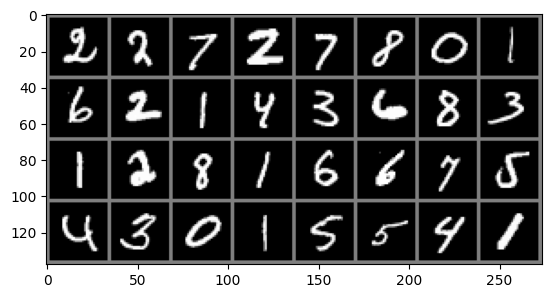

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img, filename=''):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if filename == '':
        plt.show()
    else:
        plt.savefig(name)

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


## Define a MLP


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# this class define the architecture
class NetMLP(nn.Module):
    # in the constructor, the usefull layers are defined,
    # with the correct input/output dimensions
    def __init__(self, hiddencells = 100):
        super(NetMLP, self).__init__()
        self.fc1 = nn.Linear(32 * 32 , hiddencells)
        self.fc2 = nn.Linear(hiddencells, 10)

    # in the forward function, the layers are applied as functions
    # with the correct order and on a specific data x
    # dimensions of x are [minibatch size, H, W]
    def forward(self, x):
        x = x.view(-1, 32 * 32)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

    2     2     7     2


In [ ]:
########################################################################
# Define the network to use :
net = NetMLP(100)
net.to(device) # move it to GPU or CPU
# show the structure :
print(net)

NetMLP(
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


# Define a Loss function and the optimizer

In [ ]:
# Let's use a Classification Cross-Entropy loss and SGD with momentum.

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the network
This is the core part of the code, implementing the training loops. Answer Q1 with code.

In [ ]:

# Definition of arrays to store the results and draw the learning curves
val_err_array = np.array([])
train_err_array = np.array([])
nb_sample_array = np.array([])

# best system results
best_val_loss = 1000000
best_nb_sample = 0
best_model =  copy.deepcopy(net)

nb_used_sample = 0
running_loss = 0.0
num_epochs = 5
print_every = 200

for epoch in range(num_epochs):  # loop over the dataset multiple times
    start_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) # if possible, move them to GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # count how many samples have been used during the training
        nb_used_sample += minibatchsize
        # print/save statistics
        running_loss += loss.item()
        if nb_used_sample % (print_every * minibatchsize) == 0:    # print every ""print_every"" mini-batches
            train_err = (running_loss / (print_every * minibatchsize))
            print('Epoch %d batch %5d ' % (epoch + 1, i + 1))
            print('Train loss : %.3f' % train_err)
            running_loss = 0.0
            #evaluation on validation set
            totalValLoss = 0.0
            with torch.no_grad():
                for data in validationloader:
                    images, labels = data
                    images, labels = images.to(device), labels.to(device)
                    outputs = net(images)
                    loss = criterion(outputs, labels)
                    totalValLoss += loss.item()
            val_err = (totalValLoss / len(validationset))
            print('Validation loss mean : %.3f' % val_err)
            train_err_array = np.append(train_err_array, train_err)
            val_err_array = np.append(val_err_array, val_err)
            nb_sample_array = np.append(nb_sample_array, nb_used_sample)

            # save the model only when loss is better

            if val_err < best_val_loss:
                best_val_loss = val_err
                best_nb_sample = nb_used_sample
                best_model = copy.deepcopy(net)
                print('New best model saved at %d samples' % best_nb_sample)
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))

print('Finished Training')

#draw the graph


### save the best model :
# torch.save(best_model.state_dict(), "./best_model.nn")


Epoch 1 batch   200 
Train loss : 0.072
Validation loss mean : 0.071
New best model saved at 6400 samples
Epoch 1 batch   400 
Train loss : 0.070
Validation loss mean : 0.069
New best model saved at 12800 samples
Epoch 1 batch   600 
Train loss : 0.068
Validation loss mean : 0.067
New best model saved at 19200 samples
Epoch 1 of 5 took 13.757s
Epoch 2 batch   175 
Train loss : 0.065
Validation loss mean : 0.064
New best model saved at 25600 samples
Epoch 2 batch   375 
Train loss : 0.062
Validation loss mean : 0.061
New best model saved at 32000 samples
Epoch 2 batch   575 
Train loss : 0.060
Validation loss mean : 0.059
New best model saved at 38400 samples
Epoch 2 of 5 took 13.289s
Epoch 3 batch   150 
Train loss : 0.058
Validation loss mean : 0.058
New best model saved at 44800 samples
Epoch 3 batch   350 
Train loss : 0.057
Validation loss mean : 0.057
New best model saved at 51200 samples
Epoch 3 batch   550 
Train loss : 0.056
Validation loss mean : 0.056
New best model saved at 

## Prepare and draw the training curves

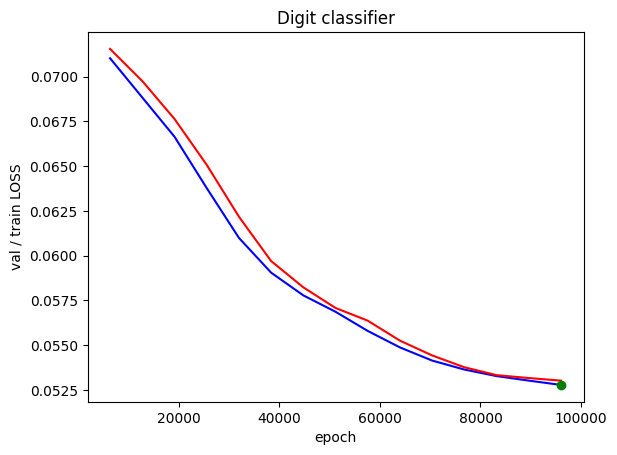

In [ ]:
plt.clf()
plt.xlabel('epoch')
plt.ylabel('val / train LOSS')
plt.title('Digit classifier')
plt.plot(nb_sample_array.tolist(), val_err_array.tolist(), 'b',nb_sample_array.tolist(), train_err_array.tolist(), 'r', [best_nb_sample], [best_val_loss],         'go')
plt.show()

## Test the network on the test data

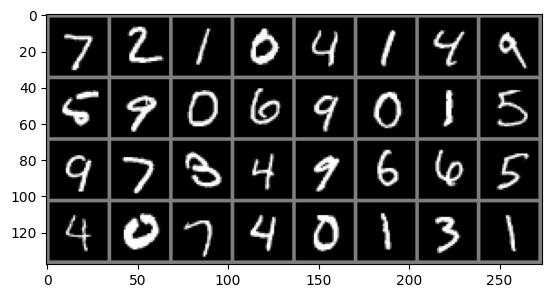

GroundTruth:      7     2     1     0     4     1     4     9     5     9     0     6     9     0     1     5     9     7     3     4     9     6     6     5     4     0     7     4     0     1     3     1
Predicted:      7     2     1     0     4     1     4     9     6     9     0     6     9     0     1     3     9     7     3     4     9     6     6     8     4     0     7     4     0     1     3     1


In [ ]:
# first on few sample, just to see real results
dataiter = iter(testloader)
images_cpu, labels_cpu = next(dataiter)
images, labels = images_cpu.to(device), labels_cpu.to(device)
plt.clf()
imshow(torchvision.utils.make_grid(images_cpu))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(minibatchsize)))
# activate the net with these examples
outputs = best_model(images)

# get the maximum class number for each sample, but print the corresponding class name
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(minibatchsize)))

In [ ]:
# Test now  on the whole test dataset.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %3.2f %%' % (
    100.0 * correct / total))

Accuracy of the network on the test images: 82.24 %


In [ ]:
# Check the results for each class
class_correct = list(0. for i in range(nb_classes))
class_total = list(0. for i in range(nb_classes))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# compute ... and show results

for i in range(nb_classes):
    if class_total[i] > 0 :
        print('Accuracy of %5s : %3.2f %% (%d/%d)' % (
            classes[i], 100.0 * class_correct[i] / class_total[i], class_correct[i] , class_total[i]))
    else:
        print('No %5s sample' % (classes[i]))

Accuracy of     0 : 96.63 % (947/980)
Accuracy of     1 : 97.44 % (1106/1135)
Accuracy of     2 : 83.24 % (859/1032)
Accuracy of     3 : 91.09 % (920/1010)
Accuracy of     4 : 93.58 % (919/982)
Accuracy of     5 : 0.00 % (0/892)
Accuracy of     6 : 94.47 % (905/958)
Accuracy of     7 : 89.69 % (922/1028)
Accuracy of     8 : 82.55 % (804/974)
Accuracy of     9 : 83.45 % (842/1009)


Epoch 1 batch   200 
Train loss : 0.071
Validation loss mean : 0.071
New best model saved at 6400 samples
Epoch 1 batch   400 
Train loss : 0.070
Validation loss mean : 0.069
New best model saved at 12800 samples
Epoch 1 batch   600 
Train loss : 0.067
Validation loss mean : 0.065
New best model saved at 19200 samples
Epoch 1 of 10 took 13.607s
Epoch 2 batch   175 
Train loss : 0.063
Validation loss mean : 0.062
New best model saved at 25600 samples
Epoch 2 batch   375 
Train loss : 0.061
Validation loss mean : 0.060
New best model saved at 32000 samples
Epoch 2 batch   575 
Train loss : 0.059
Validation loss mean : 0.059
New best model saved at 38400 samples
Epoch 2 of 10 took 13.750s
Epoch 3 batch   150 
Train loss : 0.058
Validation loss mean : 0.058
New best model saved at 44800 samples
Epoch 3 batch   350 
Train loss : 0.058
Validation loss mean : 0.058
New best model saved at 51200 samples
Epoch 3 batch   550 
Train loss : 0.057
Validation loss mean : 0.057
New best model saved a

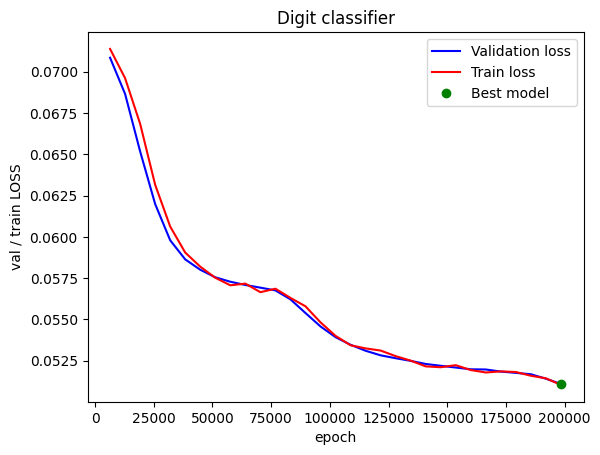

Accuracy of the network on the test images: 87.56 %


In [ ]:
#Answer here Q2 (functional training).

def train_network(net, trainloader,validationloader, validationset, criterion, optimizer, num_epochs=5, print_every=200):
    # Definition of arrays to store the results and draw the learning curves
    val_err_array = np.array([])
    train_err_array = np.array([])
    nb_sample_array = np.array([])

    # best system results
    best_val_loss = 1000000
    best_nb_sample = 0
    best_model =  copy.deepcopy(net)

    nb_used_sample = 0
    running_loss = 0.0

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        start_time = time.time()
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # count how many samples have been used during the training
            nb_used_sample += minibatchsize
            # print/save statistics
            running_loss += loss.item()
            if nb_used_sample % (print_every * minibatchsize) == 0:    # print every ""print_every"" mini-batches
                train_err = (running_loss / (print_every * minibatchsize))
                print('Epoch %d batch %5d ' % (epoch + 1, i + 1))
                print('Train loss : %.3f' % train_err)
                running_loss = 0.0
                #evaluation on validation set
                totalValLoss = 0.0
                with torch.no_grad():
                    for data in validationloader:
                        images, labels = data
                        images, labels = images.to(device), labels.to(device)
                        outputs = net(images)
                        loss = criterion(outputs, labels)
                        totalValLoss += loss.item()
                val_err = (totalValLoss / len(validationset))
                print('Validation loss mean : %.3f' % val_err)
                train_err_array = np.append(train_err_array, train_err)
                val_err_array = np.append(val_err_array, val_err)
                nb_sample_array = np.append(nb_sample_array, nb_used_sample)

                # save the model and update best_val_loss and best_nb_sample only when loss is better
                if val_err < best_val_loss:
                    best_val_loss = val_err
                    best_nb_sample = nb_used_sample
                    best_model =  copy.deepcopy(net)
                    print('New best model saved at %d samples' % best_nb_sample)

        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))

    print('Finished Training')

    # learning curves
    plt.clf()
    plt.xlabel('epoch')
    plt.ylabel('val / train LOSS')
    plt.title('Digit classifier')
    plt.plot(nb_sample_array.tolist(), val_err_array.tolist(), 'b',nb_sample_array.tolist(), train_err_array.tolist(), 'r', [best_nb_sample], [best_val_loss],         'go')
    plt.legend(['Validation loss', 'Train loss', 'Best model'])
    plt.show()
    return best_model


def test_accuracy(net, testloader, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

test_net = NetMLP(100)
test_net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(test_net.parameters(), lr=0.001, momentum=0.9)

best_model = train_network(test_net, trainloader, validationloader, validationset, criterion, optimizer, num_epochs = 10, print_every = 200)
accuracy = test_accuracy(best_model, testloader, device)
print('Accuracy of the network on the test images: %3.2f %%' % accuracy)


# Answer here Q3 (number of weights)

1. On a une première couche `fc1` qui connecte l'input avec l'hidden layer. On a un input de $(32*32)$ qui se connecte à $(100)$ hidden cell. En plus de ça, chaque neurone de l'hidden layer a un biais donc on a un total de poids pour la première couche de $(32*32*100 + 100)$.

2. On a une seconde couche `fc2` qui connecte l'hidden layer à l'output. On a toujours les 100 cell de l'hidden layer qui se connecte à la sortie qui a 10 cell. On a aussi un biais pour les 10 cellule de la sortie, ce qui fait un total de $(100*10+10)$

Ce qui nous fait un total de $((32 * 32) * 100 + 100) + (100 * 10 + 10) = 103 510$

Epoch 1 of 1000 took 0.280s
Epoch 2 of 1000 took 0.271s
Epoch 3 of 1000 took 0.414s
Epoch 4 of 1000 took 0.458s
Epoch 5 of 1000 took 0.582s
Epoch 6 of 1000 took 0.492s
Epoch 7 of 1000 took 0.303s
Epoch 8 of 1000 took 0.544s
Epoch 9 of 1000 took 0.517s
Epoch 10 of 1000 took 0.607s
Epoch 11 of 1000 took 0.549s
Epoch 12 of 1000 took 0.629s
Epoch 13 batch     8 
Train loss : 0.072
Validation loss mean : 0.072
New best model saved at 6400 samples
Epoch 13 of 1000 took 12.034s
Epoch 14 of 1000 took 0.279s
Epoch 15 of 1000 took 0.305s
Epoch 16 of 1000 took 0.221s
Epoch 17 of 1000 took 0.242s
Epoch 18 of 1000 took 0.210s
Epoch 19 of 1000 took 0.142s
Epoch 20 of 1000 took 0.143s
Epoch 21 of 1000 took 0.141s
Epoch 22 of 1000 took 0.143s
Epoch 23 of 1000 took 0.147s
Epoch 24 of 1000 took 0.149s
Epoch 25 batch    16 
Train loss : 0.071
Validation loss mean : 0.071
New best model saved at 12800 samples
Epoch 25 of 1000 took 7.475s
Epoch 26 of 1000 took 0.139s
Epoch 27 of 1000 took 0.146s
Epoch 28 o

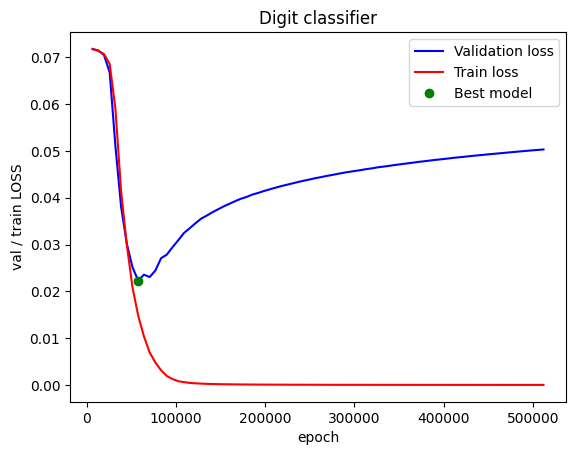

Accuracy of the network on the test images: 78.39 %


In [ ]:
#Answer here Q4 (overfitting MNIST).

# On va utiliser un modèle bcp plus complexe et un jeu de données plus petit pour voir l'overfitting
# Pour être sûr de l'overfitting, on va aussi augmenter le nombre d'epochs

transform = transforms.Compose(
    [transforms.Pad(2),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

class ComplexMLP(nn.Module):
    def __init__(self, hiddencells=1000):
        super(ComplexMLP, self).__init__()
        self.fc1 = nn.Linear(32 * 32, hiddencells)
        self.fc2 = nn.Linear(hiddencells, hiddencells)
        self.fc3 = nn.Linear(hiddencells, hiddencells)
        self.fc4 = nn.Linear(hiddencells, hiddencells)
        self.fc5 = nn.Linear(hiddencells, 10)

    def forward(self, x):
        x = x.view(-1, 32 * 32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)  # Removed softmax here
        return x

# size of the mini batch
minibatchsize = 32

datadir = './data'
fulltrainset = torchvision.datasets.MNIST(root=datadir, train=True,
                                        download=True, transform=transform)

#split the full train part as train and validation (500 samples for the training to overfit)
trainset, validationset, _ignored_part = torch.utils.data.random_split(fulltrainset, [500,30000, 29500])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatchsize,
                                          shuffle=True, num_workers=0)

validationloader = torch.utils.data.DataLoader(validationset, batch_size=minibatchsize,
                                          shuffle=False, num_workers=0)

testset = torchvision.datasets.MNIST(root=datadir, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatchsize,
                                         shuffle=False, num_workers=0)

# define the set of class names :
classes = range(0,10)
nb_classes = len(classes)

# Train the network
overfit_net = ComplexMLP(100)
overfit_net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(overfit_net.parameters(), lr=0.001, momentum=0.9)

best_model = train_network(overfit_net, trainloader, validationloader, validationset, criterion, optimizer, num_epochs = 1000, print_every = 200)
accuracy = test_accuracy(best_model, testloader, device)
print('Accuracy of the network on the test images: %3.2f %%' % accuracy)

